# Library Load

In [1]:
# 기본 library
import pandas as pd
import numpy as np
import re

# 시각화 library 
import seaborn as sns
import matplotlib.pyplot as plt

# 평가지표 library
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# tensorflow library
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

from keras.utils import np_utils

# nltk library
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# 오류 관련 library
import warnings 
warnings.filterwarnings(action='ignore')

# Python, NumPy, TensorFlow의 random seed 고정
seed = 42
tf.keras.utils.set_random_seed(seed)

[nltk_data] Downloading package stopwords to /home/work/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/work/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/work/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Dataset Load

In [2]:
path = "novel_writer_data/"

In [3]:
train = pd.read_csv(path+'train.csv', encoding = 'utf-8')
test = pd.read_csv(path+'test_x.csv', encoding = 'utf-8')

In [4]:
display(train.head(2))
display(test.head(2))

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2


,index,text
0,0,“Not at all. I think she is one of the most ch...
1,1,"""No,"" replied he, with sudden consciousness, ""..."


In [5]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0)

# Text data Preprocessing

In [6]:
train['text'][4]

'“Have mercy, gentlemen!” odin flung up his hands. “Don’t write that, anyway; have some shame. Here I’ve torn my heart asunder before you, and you seize the opportunity and are fingering the wounds in both halves.... Oh, my God!”'

> **특수문자 제거하기**

In [7]:
def remove_special_characters(text):
    return re.sub(r'[^A-Za-z 0-9]','',text)

In [8]:
train['text'] = train['text'].apply(remove_special_characters)
test['text'] = test['text'].apply(remove_special_characters)

In [9]:
# 확인
train['text'][4]

'Have mercy gentlemen odin flung up his hands Dont write that anyway have some shame Here Ive torn my heart asunder before you and you seize the opportunity and are fingering the wounds in both halves Oh my God'

> **모두 소문자로 변경**

In [10]:
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()

In [11]:
train['text'][4]

'have mercy gentlemen odin flung up his hands dont write that anyway have some shame here ive torn my heart asunder before you and you seize the opportunity and are fingering the wounds in both halves oh my god'

> **연속된 공백을 하나의 공백으로 통일**

In [12]:
train['text'] = train['text'].apply(lambda x: re.sub(' +', ' ', x))
test['text'] = test['text'].apply(lambda x: re.sub(' +', ' ', x))

In [13]:
train['text'][4]

'have mercy gentlemen odin flung up his hands dont write that anyway have some shame here ive torn my heart asunder before you and you seize the opportunity and are fingering the wounds in both halves oh my god'

> **불용어 제거**

In [14]:
stop_words = set(stopwords.words('english')) 
stop_words = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip() not in stop_words:
            final_text.append(i.strip())
    return " ".join(final_text)

In [15]:
train['text'] = train['text'].apply(remove_stopwords)
test['text'] = test['text'].apply(remove_stopwords)

In [16]:
train['text'][4]

'mercy gentlemen odin flung hands dont write anyway shame ive torn heart asunder seize opportunity fingering wounds halves oh god'

> **Stemming and Lemmatization**

* Stemming과 Lemmatization이 작가의 문체를 해칠 수 있다고 생각이 들었지만, 실제로는 적용했을 때 모델의 성능이 더 좋을 수도 있으니 따로 적용해준 **파생 변수(text_S, text_L)**를 생성해 비교해보기 함

In [17]:
# text_S

In [18]:
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

In [19]:
train['text_S'] = train['text'].apply(stem_words)
test['text_S'] = test['text'].apply(stem_words)

In [20]:
train['text_S'][4]

'merci gentlemen odin flung hand dont write anyway shame ive torn heart asund seiz opportun finger wound halv oh god'

In [21]:
# text_L

In [22]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [23]:
train['text_L'] = train['text'].apply(lemmatize_words)
test['text_L'] = test['text'].apply(lemmatize_words)

In [24]:
train['text_L'][4]

'mercy gentleman odin flung hand dont write anyway shame ive torn heart asunder seize opportunity fingering wound half oh god'

# Data Visualization

> **작가별 데이터 개수 비교**

Text(0.5, 1.0, 'Samples per each class (Training set)')

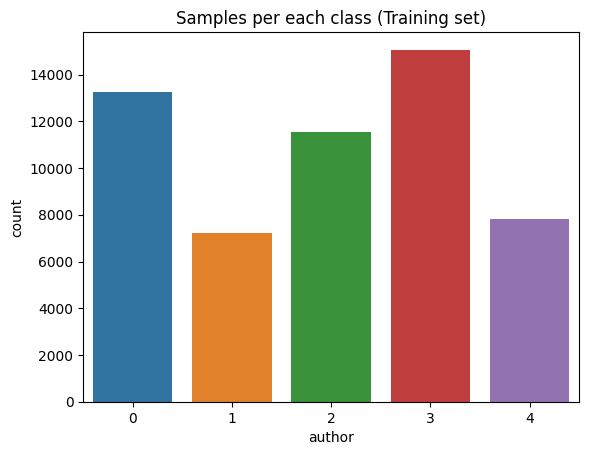

In [25]:
sns.countplot(data=train, x="author").set_title("Samples per each class (Training set)")

> **단어 개수로 문장 길이 분포도 확인**

In [26]:
train['doc_len'] = train["text"].apply(lambda words:len(words.split()))
train['doc_len'].sample(5)

34282    32
47847    37
47381    24
39571    14
52923    26
Name: doc_len, dtype: int64

In [27]:
def plot_doc_length(df):
    mean_doc_len = int(np.round(df["doc_len"].mean()))
    sns.distplot(df["doc_len"], hist=True, kde=True, label="Document Length")
    plt.axvline(x=mean_doc_len, color="k", linestyle="--", label=f"Sequence length mean:{mean_doc_len}")
    plt.title("Document Length")
    plt.legend()
    plt.show()

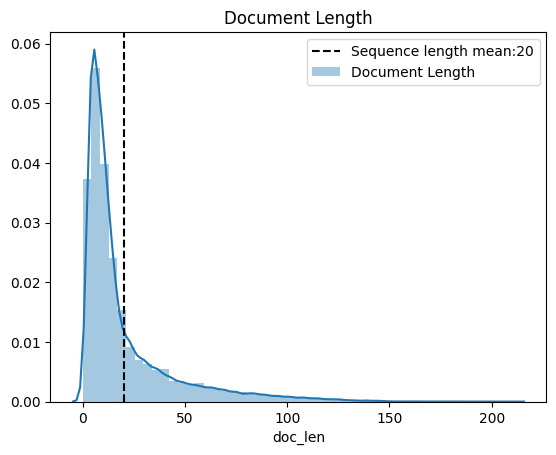

In [28]:
plot_doc_length(train)

In [29]:
print(f"가장 긴 문장은 {train['doc_len'].max()}개의 단어를, 가장 짧은 문장은 {train['doc_len'].min()}개의 단어를 가지고 있습니다.")

가장 긴 문장은 211개의 단어를, 가장 짧은 문장은 0개의 단어를 가지고 있습니다.


* **sequence**에서 **max length**를 적당히 **150개**로 지정!

# Text data Vectorization

In [30]:
# Choose the text feauture you want to use
# "text" or "text_S" or "text_L"
text_feauture = "text"
label = "author"

In [31]:
X_train = np.array(train[text_feauture])
X_test = np.array(test[text_feauture])
y_train = np.array(train[label])

In [32]:
print("X_train shape : " , X_train.shape)
print("X_test shape : " , X_test.shape)
print("y_train shape : " , y_train.shape)

X_train shape :  (54879,)
X_test shape :  (19617,)
y_train shape :  (54879,)


> **Parameter Setting**

In [33]:
vocab_size = 2000 
embedding_dim = 200  
max_length = 150 
padding_type='post'

> **Tokenizer**

In [34]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)

In [35]:
print(list(tokenizer.word_index.items())[:5])

[('odin', 1), ('not', 2), ('said', 3), ('no', 4), ('one', 5)]


> **Sequence**

In [36]:
sequences_train = tokenizer.texts_to_sequences(X_train) 
sequences_test = tokenizer.texts_to_sequences(X_test) 

In [37]:
for i in range(5):
    print(f"train[{i}] : {sequences_train[i]}\n")

train[0] : [141, 20, 20, 316, 21, 229, 36, 452, 1202, 1701, 1207, 45, 57, 1, 1214]

train[1] : [217, 58, 221]

train[2] : [682, 5, 59, 250, 38, 194, 1232, 485, 2, 625, 499, 699, 501, 6, 1, 79, 107, 1, 671, 862, 50, 194, 424, 289, 3]

train[3] : [251, 874, 1237, 43, 830, 1504, 121, 254, 24, 1147, 617, 502, 1, 66, 1735, 135, 399, 1789, 1626, 617, 106, 1901, 137, 1790]

train[4] : [1381, 346, 1, 1555, 106, 31, 488, 1478, 975, 211, 104, 891, 83, 200]



> **Padding**

In [38]:
train_input = pad_sequences(sequences_train, padding=padding_type, maxlen=max_length)
test_input = pad_sequences(sequences_test, padding=padding_type, maxlen=max_length)

In [39]:
print("train_input shape : " , train_input.shape)
print("test_input shape : " , test_input.shape)

train_input shape :  (54879, 150)
test_input shape :  (19617, 150)


# Data setting Before model train

> **label : One-hot-encoding**

In [40]:
train_label = np_utils.to_categorical(y_train)
print("train_label shape : " , train_label.shape)

train_label shape :  (54879, 5)


> **train valid dataset split**

In [41]:
train_input, valid_input, train_label, valid_label = train_test_split(
    train_input, train_label, test_size=0.2, random_state=42, stratify=train_label)

In [42]:
print("train_input shape : " , train_input.shape)
print("train_label shape : " , train_label.shape)
print("==========================================")
print("valid_input shape : " , valid_input.shape)
print("valid_label shape : " , valid_label.shape)

train_input shape :  (43903, 150)
train_label shape :  (43903, 5)
valid_input shape :  (10976, 150)
valid_label shape :  (10976, 5)


# Modeling

> **parameter setting**

In [43]:
epoch = 10
batch_size = 100

> **simple RNN**

In [44]:
# Model Bulid
model1 = Sequential([Embedding(vocab_size, embedding_dim, input_length = max_length),
        tf.keras.layers.SimpleRNN(units = 64, return_sequences = True),
        tf.keras.layers.SimpleRNN(units = 64, return_sequences = True),
        tf.keras.layers.SimpleRNN(units = 64),
        Dense(5, activation='softmax')
    ])

2022-12-18 17:40:10.770650: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-18 17:40:11.470311: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1553] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6988 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:3f:00.0, compute capability: 7.5


In [45]:
# Model compile
model1.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy']) 

In [46]:
# model summary
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 200)          400000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 150, 64)           16960     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 150, 64)           8256      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 433,797
Trainable params: 433,797
Non-trainable params: 0
_________________________________________________________________


In [47]:
# model train
history = model1.fit(train_input, train_label,
                    validation_data=(valid_input, valid_label),
                    epochs=epoch,
                    batch_size=batch_size)

Epoch 1/10
440/440 [==============================] - 166s 373ms/step - loss: 1.5793 - accuracy: 0.2633 - val_loss: 1.5754 - val_accuracy: 0.2745
Epoch 2/10
440/440 [==============================] - 165s 375ms/step - loss: 1.5760 - accuracy: 0.2676 - val_loss: 1.5731 - val_accuracy: 0.2745
Epoch 3/10
440/440 [==============================] - 165s 375ms/step - loss: 1.5759 - accuracy: 0.2656 - val_loss: 1.5700 - val_accuracy: 0.2745
Epoch 4/10
440/440 [==============================] - 165s 374ms/step - loss: 1.5724 - accuracy: 0.2687 - val_loss: 1.5711 - val_accuracy: 0.2668
Epoch 5/10
440/440 [==============================] - 165s 375ms/step - loss: 1.5725 - accuracy: 0.2690 - val_loss: 1.5742 - val_accuracy: 0.2669
Epoch 6/10
440/440 [==============================] - 169s 385ms/step - loss: 1.5717 - accuracy: 0.2709 - val_loss: 1.5704 - val_accuracy: 0.2669
Epoch 7/10
440/440 [==============================] - 165s 375ms/step - loss: 1.5724 - accuracy: 0.2700 - val_loss: 1.5691 -

In [48]:
# train result visualization
df_history1 = pd.DataFrame(history.history)
df_history1.tail(3)

,loss,accuracy,val_loss,val_accuracy
7,1.572135,0.268865,1.569712,0.274508
8,1.571792,0.271098,1.574441,0.250547
9,1.572636,0.267658,1.573954,0.274508


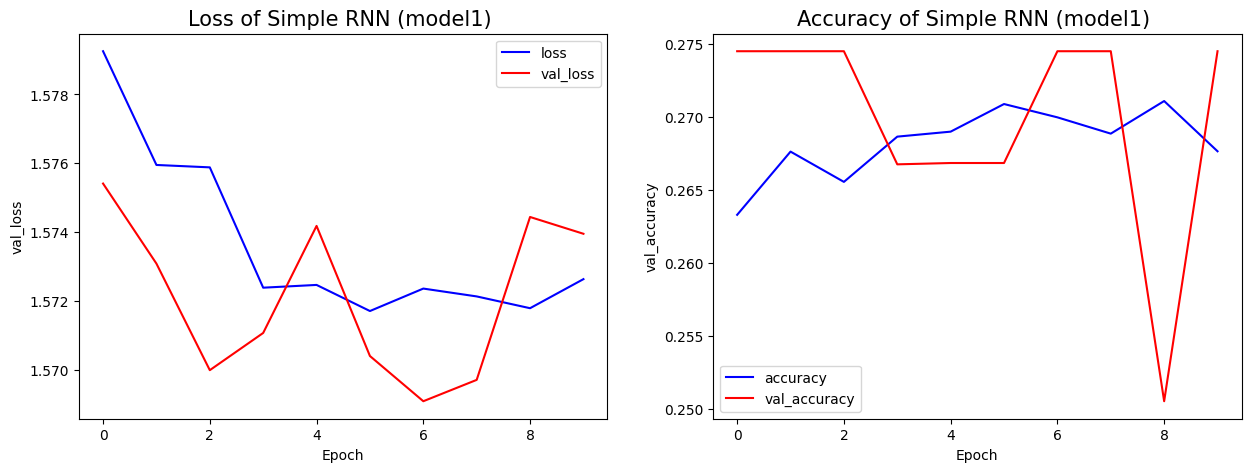

In [49]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

# loss 
sns.lineplot(data=df_history1, x=df_history1.index, y='loss',label='loss', color='blue', ax=axes[0])
sns.lineplot(data=df_history1, x=df_history1.index, y='val_loss',label='val_loss', color='red', ax=axes[0])
axes[0].set_title('Loss of Simple RNN (model1) ', fontsize= 15)
axes[0].set_xlabel('Epoch')

# accuracy
sns.lineplot(data=df_history1, x=df_history1.index, y='accuracy',label='accuracy', color='blue', ax=axes[1])
sns.lineplot(data=df_history1, x=df_history1.index, y='val_accuracy',label='val_accuracy', color='red', ax=axes[1])
axes[1].set_title('Accuracy of Simple RNN (model1) ', fontsize= 15)
axes[1].set_xlabel('Epoch')

fig.show()

> **단방향 LSTM**

In [50]:
# Model Bulid
model2 = Sequential([Embedding(vocab_size, embedding_dim, input_length =max_length),
        tf.keras.layers.LSTM(units = 64, return_sequences = True),
        tf.keras.layers.LSTM(units = 64, return_sequences = True),
        tf.keras.layers.LSTM(units = 64),
        Dense(5, activation='softmax')
    ])

In [51]:
# Model compile
model2.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy']) 

In [52]:
# model summary
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 200)          400000    
                                                                 
 lstm (LSTM)                 (None, 150, 64)           67840     
                                                                 
 lstm_1 (LSTM)               (None, 150, 64)           33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 534,213
Trainable params: 534,213
Non-trainable params: 0
_________________________________________________________________


In [53]:
# model train
history = model2.fit(train_input, train_label,
                    validation_data=(valid_input, valid_label),
                    epochs=epoch,
                    batch_size=batch_size)

Epoch 1/10


2022-12-18 18:07:54.851046: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


440/440 [==============================] - 15s 25ms/step - loss: 1.5726 - accuracy: 0.2722 - val_loss: 1.5711 - val_accuracy: 0.2745
Epoch 2/10
440/440 [==============================] - 10s 22ms/step - loss: 1.5709 - accuracy: 0.2745 - val_loss: 1.5708 - val_accuracy: 0.2745
Epoch 3/10
440/440 [==============================] - 10s 22ms/step - loss: 1.5710 - accuracy: 0.2745 - val_loss: 1.5706 - val_accuracy: 0.2745
Epoch 4/10
440/440 [==============================] - 10s 23ms/step - loss: 1.5708 - accuracy: 0.2745 - val_loss: 1.5714 - val_accuracy: 0.2745
Epoch 5/10
440/440 [==============================] - 10s 23ms/step - loss: 1.5707 - accuracy: 0.2745 - val_loss: 1.5703 - val_accuracy: 0.2745
Epoch 6/10
440/440 [==============================] - 10s 22ms/step - loss: 1.5707 - accuracy: 0.2745 - val_loss: 1.5705 - val_accuracy: 0.2745
Epoch 7/10
440/440 [==============================] - 10s 22ms/step - loss: 1.5706 - accuracy: 0.2745 - val_loss: 1.5704 - val_accuracy: 0.2745
Epo

In [54]:
# train result visualization
df_history2 = pd.DataFrame(history.history)
df_history2.tail(3)

,loss,accuracy,val_loss,val_accuracy
7,1.570592,0.274469,1.570394,0.274508
8,1.570760,0.274469,1.570283,0.274508
9,1.570599,0.274469,1.570661,0.274508


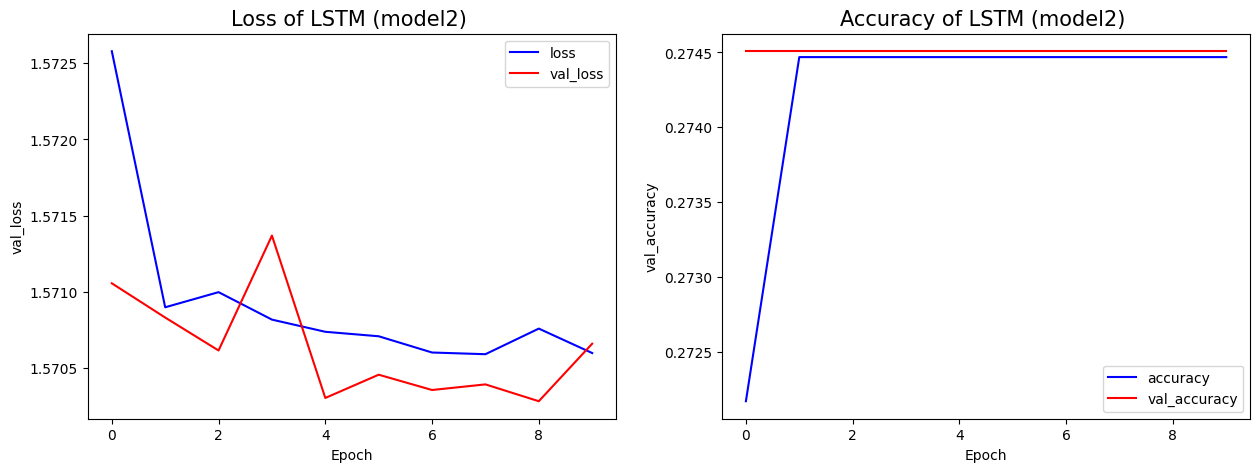

In [55]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

# loss 
sns.lineplot(data=df_history2, x=df_history2.index, y='loss',label='loss', color='blue', ax=axes[0])
sns.lineplot(data=df_history2, x=df_history2.index, y='val_loss',label='val_loss', color='red', ax=axes[0])
axes[0].set_title('Loss of LSTM (model2) ', fontsize= 15)
axes[0].set_xlabel('Epoch')

# accuracy
sns.lineplot(data=df_history2, x=df_history2.index, y='accuracy',label='accuracy', color='blue', ax=axes[1])
sns.lineplot(data=df_history2, x=df_history2.index, y='val_accuracy',label='val_accuracy', color='red', ax=axes[1])
axes[1].set_title('Accuracy of LSTM (model2) ', fontsize= 15)
axes[1].set_xlabel('Epoch')

fig.show()

> **양방향 LSTM**

In [56]:
# Model Bulid
model3 = Sequential([Embedding(vocab_size, embedding_dim, input_length =max_length),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64)),
        Dense(5, activation='softmax')
    ])

In [57]:
# Model compile
model3.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy']) 

In [58]:
# model summary
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 200)          400000    
                                                                 
 bidirectional (Bidirectiona  (None, 150, 128)         135680    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 150, 128)         98816     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                      

In [59]:
# model train
history = model3.fit(train_input, train_label,
                    validation_data=(valid_input, valid_label),
                    epochs=epoch+40,
                    batch_size=batch_size)

Epoch 1/50
440/440 [==============================] - 26s 43ms/step - loss: 1.1177 - accuracy: 0.5425 - val_loss: 0.9575 - val_accuracy: 0.6331
Epoch 2/50
440/440 [==============================] - 17s 39ms/step - loss: 0.8664 - accuracy: 0.6651 - val_loss: 0.9105 - val_accuracy: 0.6516
Epoch 3/50
440/440 [==============================] - 17s 40ms/step - loss: 0.8005 - accuracy: 0.6939 - val_loss: 0.9060 - val_accuracy: 0.6532
Epoch 4/50
440/440 [==============================] - 17s 39ms/step - loss: 0.7625 - accuracy: 0.7069 - val_loss: 0.9240 - val_accuracy: 0.6499
Epoch 5/50
440/440 [==============================] - 17s 39ms/step - loss: 0.7272 - accuracy: 0.7186 - val_loss: 0.9127 - val_accuracy: 0.6530
Epoch 6/50
440/440 [==============================] - 17s 39ms/step - loss: 0.6991 - accuracy: 0.7304 - val_loss: 0.9346 - val_accuracy: 0.6481
Epoch 7/50
440/440 [==============================] - 17s 39ms/step - loss: 0.6719 - accuracy: 0.7415 - val_loss: 0.9537 - val_accuracy:

In [60]:
# train result visualization
df_history3 = pd.DataFrame(history.history)
df_history3.tail(3)

,loss,accuracy,val_loss,val_accuracy
47,0.089229,0.967269,3.119460,0.602314
48,0.081358,0.969228,3.170521,0.601767
49,0.074983,0.971984,3.326131,0.604227


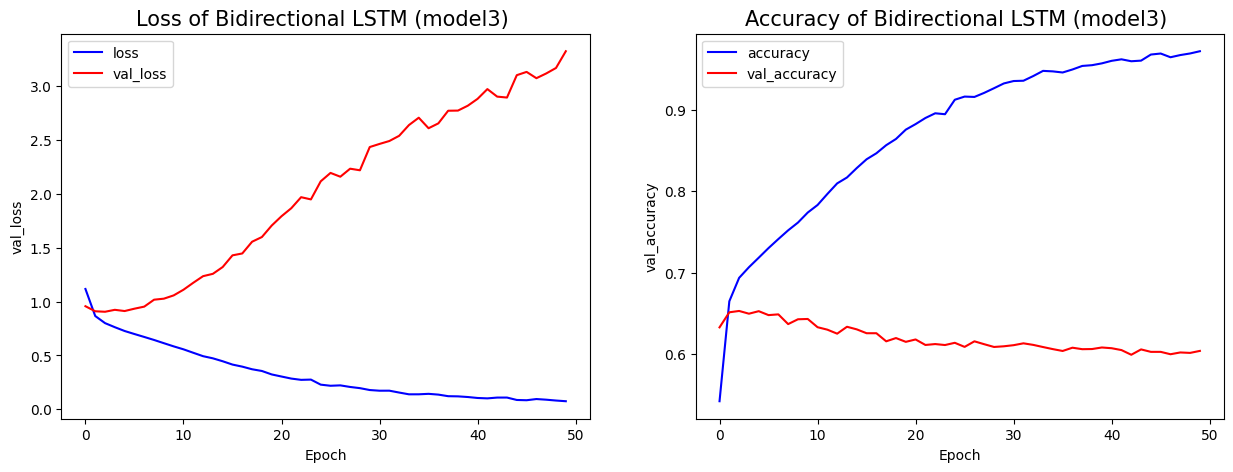

In [61]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

# loss 
sns.lineplot(data=df_history3, x=df_history3.index, y='loss',label='loss', color='blue', ax=axes[0])
sns.lineplot(data=df_history3, x=df_history3.index, y='val_loss',label='val_loss', color='red', ax=axes[0])
axes[0].set_title('Loss of Bidirectional LSTM (model3) ', fontsize= 15)
axes[0].set_xlabel('Epoch')

# accuracy
sns.lineplot(data=df_history3, x=df_history3.index, y='accuracy',label='accuracy', color='blue', ax=axes[1])
sns.lineplot(data=df_history3, x=df_history3.index, y='val_accuracy',label='val_accuracy', color='red', ax=axes[1])
axes[1].set_title('Accuracy of Bidirectional LSTM (model3) ', fontsize= 15)
axes[1].set_xlabel('Epoch')

fig.show()

* 중간에 과적합이 일어난 것 같은 양상을 보인다.    
* model 1~3 중 3이 가장 좋은 성능을 보인다.    

**과적합을 방지하기 위해 교차 검증을 통해 모델 일반화를 시도하자**

> **교차 검증 적용 모델**

In [62]:
fold = 5
epoch = 10
batch_size = 512

In [63]:
# 나눴던 train, valid 합치기
print(f"<Before concat>\ntrain_input shape : {train_input.shape}\nvalid_input shape : {valid_input.shape}")
print(f"train_label shape : {train_label.shape}\nvalid_label shape : {valid_label.shape}")
print("================================")
train_input = np.concatenate((train_input,valid_input),axis=0)
train_label = np.concatenate((train_label,valid_label),axis=0)
print(f"<After concat>\ntrain_input shape : {train_input.shape}\ntrain_label shape : {train_label.shape}")
print("================================")

<Before concat>
train_input shape : (43903, 150)
valid_input shape : (10976, 150)
train_label shape : (43903, 5)
valid_label shape : (10976, 5)
<After concat>
train_input shape : (54879, 150)
train_label shape : (54879, 5)


In [64]:
cv = StratifiedKFold(n_splits= fold, shuffle=True, random_state=seed)

In [65]:
print(train_label[:10])
print("\n==After One-hot-eoncoding inverse==\n")
print(train_label.argmax(1)[:10])
# cv.split에 들어갈 y의 shape는 [n:]이어야 하므로
# one-hot-encoding 하였던 것은 inverse하여 삽입해야 함!

[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]

==After One-hot-eoncoding inverse==

[1 1 3 2 2 3 1 1 1 0]


In [66]:
for i, (i_train, i_valid) in enumerate(cv.split(train_input, train_label.argmax(1)), start=1):
    print("=================================================")
    print(f"{i}번째 교차 학습")
    print("=================================================")
    history = model3.fit(train_input[i_train], train_label[i_train],
                    validation_data=(train_input[i_valid], train_label[i_valid]),
                    epochs=epoch,
                    batch_size=batch_size)
    if i==1:
        total_history = history.history.copy()
    else:
        total_history['loss'].extend(history.history["loss"])
        total_history['accuracy'].extend(history.history["accuracy"])
        total_history['val_loss'].extend(history.history["val_loss"])
        total_history['val_accuracy'].extend(history.history["val_accuracy"])

1번째 교차 학습
Epoch 1/10
86/86 [==============================] - 5s 56ms/step - loss: 0.5346 - accuracy: 0.8961 - val_loss: 0.4328 - val_accuracy: 0.8966
Epoch 2/10
86/86 [==============================] - 5s 56ms/step - loss: 0.3199 - accuracy: 0.9213 - val_loss: 0.4152 - val_accuracy: 0.9002
Epoch 3/10
86/86 [==============================] - 5s 56ms/step - loss: 0.2666 - accuracy: 0.9326 - val_loss: 0.4156 - val_accuracy: 0.9000
Epoch 4/10
86/86 [==============================] - 5s 56ms/step - loss: 0.2328 - accuracy: 0.9398 - val_loss: 0.4217 - val_accuracy: 0.8979
Epoch 5/10
86/86 [==============================] - 5s 56ms/step - loss: 0.2070 - accuracy: 0.9453 - val_loss: 0.4294 - val_accuracy: 0.8961
Epoch 6/10
86/86 [==============================] - 5s 56ms/step - loss: 0.1850 - accuracy: 0.9504 - val_loss: 0.4400 - val_accuracy: 0.8949
Epoch 7/10
86/86 [==============================] - 5s 56ms/step - loss: 0.1664 - accuracy: 0.9541 - val_loss: 0.4528 - val_accuracy: 0.8919
Epo

In [67]:
# train result visualization
df_history4 = pd.DataFrame(total_history)
df_history4.tail(3)

,loss,accuracy,val_loss,val_accuracy
47,0.039958,0.983578,0.104616,0.963280
48,0.039771,0.983509,0.110304,0.961367
49,0.038900,0.983282,0.112206,0.961731


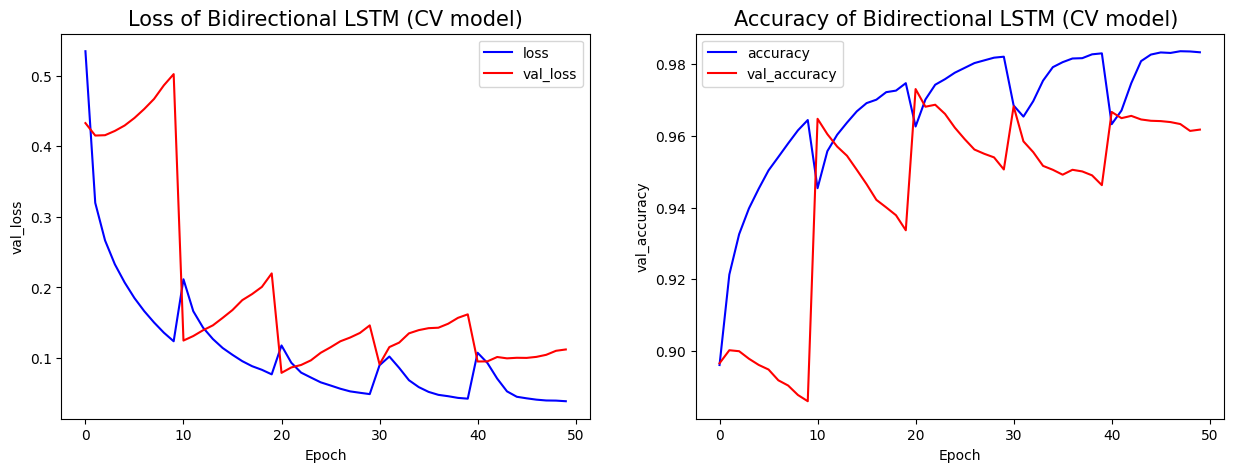

In [68]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

# loss 
sns.lineplot(data=df_history4, x=df_history4.index, y='loss',label='loss', color='blue', ax=axes[0])
sns.lineplot(data=df_history4, x=df_history4.index, y='val_loss',label='val_loss', color='red', ax=axes[0])
axes[0].set_title('Loss of Bidirectional LSTM (CV model)', fontsize= 15)
axes[0].set_xlabel('Epoch')

# accuracy
sns.lineplot(data=df_history4, x=df_history4.index, y='accuracy',label='accuracy', color='blue', ax=axes[1])
sns.lineplot(data=df_history4, x=df_history4.index, y='val_accuracy',label='val_accuracy', color='red', ax=axes[1])
axes[1].set_title('Accuracy of Bidirectional LSTM (CV model) ', fontsize= 15)
axes[1].set_xlabel('Epoch')

fig.show()

# CV Model Predict

In [69]:
(test_input.shape[0], 5)

(19617, 5)

In [70]:
y_predict = np.zeros((test_input.shape[0], 5))
y_predict

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [71]:
for i, (i_train, i_valid) in enumerate(cv.split(train_input, train_label.argmax(1)), start=1):
    print("=================================================")
    print(f"{i}번째 교차 학습")
    print("=================================================")
    history = model3.fit(train_input[i_train], train_label[i_train],
                    validation_data=(train_input[i_valid], train_label[i_valid]),
                    epochs=epoch,
                    batch_size=batch_size)
    y_predict += model3.predict(test_input) / fold

1번째 교차 학습
Epoch 1/10
86/86 [==============================] - 5s 56ms/step - loss: 0.0689 - accuracy: 0.9748 - val_loss: 0.0658 - val_accuracy: 0.9769
Epoch 2/10
86/86 [==============================] - 5s 56ms/step - loss: 0.0710 - accuracy: 0.9741 - val_loss: 0.0840 - val_accuracy: 0.9697
Epoch 3/10
86/86 [==============================] - 5s 56ms/step - loss: 0.0612 - accuracy: 0.9774 - val_loss: 0.0928 - val_accuracy: 0.9664
Epoch 4/10
86/86 [==============================] - 5s 56ms/step - loss: 0.0512 - accuracy: 0.9807 - val_loss: 0.0938 - val_accuracy: 0.9656
Epoch 5/10
86/86 [==============================] - 5s 56ms/step - loss: 0.0462 - accuracy: 0.9819 - val_loss: 0.0943 - val_accuracy: 0.9665
Epoch 6/10
86/86 [==============================] - 5s 56ms/step - loss: 0.0410 - accuracy: 0.9832 - val_loss: 0.1078 - val_accuracy: 0.9627
Epoch 7/10
86/86 [==============================] - 5s 56ms/step - loss: 0.0390 - accuracy: 0.9839 - val_loss: 0.0994 - val_accuracy: 0.9644
Epo

In [72]:
y_predict[:5]

array([[3.12201666e-07, 9.99998197e-01, 1.42436724e-06, 6.72363035e-08,
        6.60084293e-09],
       [6.88104182e-01, 5.15990469e-04, 5.39695671e-06, 6.46327548e-02,
        2.46741699e-01],
       [5.77781257e-01, 4.14684262e-07, 3.97641607e-05, 9.18780201e-06,
        4.22169391e-01],
       [3.26084761e-05, 7.50569132e-05, 9.99860361e-01, 3.09851966e-06,
        2.88616400e-05],
       [4.47398361e-01, 1.56430964e-04, 4.66817318e-01, 1.65293203e-03,
        8.39749293e-02]])

In [73]:
y_predict.shape

(19617, 5)

In [74]:
score = np.mean(history.history["val_accuracy"])
score

0.9703143417835236

# Submission

In [75]:
submit = pd.read_csv(path+'sample_submission.csv')
submit.head(2)

,index,0,1,2,3,4
0,0,0,0,0,0,0
1,1,0,0,0,0,0


In [76]:
submit[['0','1','2','3','4']] = y_predict
submit.head(5)

,index,0,1,2,3,4
0,0,3.122017e-07,9.999982e-01,0.000001,6.723630e-08,6.600843e-09
1,1,6.881042e-01,5.159905e-04,0.000005,6.463275e-02,2.467417e-01
2,2,5.777813e-01,4.146843e-07,0.000040,9.187802e-06,4.221694e-01
3,3,3.260848e-05,7.505691e-05,0.999860,3.098520e-06,2.886164e-05
4,4,4.473984e-01,1.564310e-04,0.466817,1.652932e-03,8.397493e-02


In [77]:
file_name = f"submit6_{score:.2f}.csv"
path+file_name

'novel_writer_data/submit6_0.97.csv'

In [78]:
submit.to_csv(path+file_name, index=False, encoding = 'utf-8')